**IOB-NST Algorithm based on the origial paper “A Neural Algorithm of Artistic Style” by Gatys et al.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==============================================
# IMPORT REQUIRED LIBRARIES
# ==============================================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import csv
from itertools import product
from pathlib import Path
from scipy.optimize import fmin_l_bfgs_b
from pathlib import Path
import time

# ==============================
# GLOBAL SETTINGS AND CONSTANTS
# ==============================

img_height = 512
result_prefix = "results"

# Define dataset directories

# Set content and style image folders in Google Drive
content_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/content'
style_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/style'

# Output folder (where stylized images will be saved)
output_dir = '/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/IOB-NST/top_outputs'
csv_log_path = os.path.join(output_dir, "nst_top_results_log.csv")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# ===================================
# IMAGE PROCESSING UTILITY FUNCTIONS
# ===================================

def preprocess_image(image_path, target_size):

    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):

    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939  # Add mean RGB values (reverse normalization)
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]      # Convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return Image.fromarray(x)

In [ ]:
# ==============================
# LOSS FUNCTION DEFINITIONS
# ==============================

def gram_matrix(x):
    # Ensure input is 4D: [1, H, W, C]
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    input_shape = tf.shape(x)
    H = tf.cast(input_shape[1], tf.float32)
    W = tf.cast(input_shape[2], tf.float32)
    C = tf.cast(input_shape[3], tf.float32)
    norm = H * W * C  # normalize by number of features * channels
    return tf.squeeze(result / norm, axis=0)

def total_variation_loss(x):
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(content_losses, label='Content Loss')
    plt.plot(style_losses, label='Style Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss / Score')
    plt.title('Style Transfer Metrics Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ==============================================
# EVALUATOR CLASS (FOR L-BFGS)
# ==============================================
class Evaluator:
    def __init__(self, loss_fn, shape):
        self.loss_fn = loss_fn
        self.shape = shape
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        loss, grads = self.loss_fn(x.reshape(self.shape))
        self.loss_value = loss
        self.grad_values = grads.flatten().astype('float64')
        return self.loss_value

    def grads(self, x):
        return self.grad_values

In [ ]:
# ===================================
# NEURAL STYLE TRANSFER FUNCTION
# ===================================
def run_style_transfer(content_path, style_path, output_path,
                       content_weight, style_weight, tv_weight,
                       optimizer_type, init_type,
                       iterations=300, learning_rate=10.0):

    start_time = time.time()

    global img_width
    width, height = load_img(content_path).size
    img_width = int(width * img_height / height)

    global content_losses, style_losses #,lpips_scores
    content_losses = []
    style_losses = []

    # Preprocess content and style images
    content_image = preprocess_image(content_path, (img_height, img_width))
    style_image = preprocess_image(style_path, (img_height, img_width))

    # Initialize combination image
    if init_type == "content":
        combo_img = tf.Variable(content_image, dtype=tf.float32)
    else:
        noise_img = tf.random.uniform(content_image.shape, 0, 255)
        noise_img = vgg19.preprocess_input(noise_img)
        combo_img = tf.Variable(noise_img, dtype=tf.float32)

    # Load pre-trained VGG19 model
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False

    # Layers to extract features from
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    output_layers = [content_layer] + style_layers

    # Build model that outputs selected layer activations
    outputs = [vgg.get_layer(name).output for name in output_layers]
    feature_extractor = Model(inputs=vgg.input, outputs=outputs)

    # Extract features for content and style images
    content_features = feature_extractor(content_image)[0]
    style_features = feature_extractor(style_image)[1:]

    # Define loss + gradients function
    def loss_and_grads(x_tensor):
        with tf.GradientTape() as tape:
            outputs = feature_extractor(x_tensor)
            c_out = outputs[0]
            s_outs = outputs[1:]

            c_loss = content_weight * tf.reduce_mean(tf.square(c_out - content_features))

            s_loss = 0
            for sF, sO in zip(style_features, s_outs):
                s_loss += tf.reduce_mean(tf.square(gram_matrix(sF) - gram_matrix(sO)))

            s_loss *= style_weight / len(style_layers)
            tv_loss = tv_weight * total_variation_loss(x_tensor)
            total = c_loss + s_loss + tv_loss

        grads = tape.gradient(total, x_tensor)

        return total, grads, c_loss, s_loss

    # Optimizer
    if optimizer_type == 'adam':
            optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

            #Optimization loop
            for i in range(iterations):
                loss, grads, c_l, s_l = loss_and_grads(combo_img)
                optimizer.apply_gradients([(grads, combo_img)])

                #Track metrics
                content_losses.append(c_l.numpy())
                style_losses.append(s_l.numpy())

                if (i+1) % 10 == 0:
                    print(f"[{i+1}/{iterations}] Total: {loss.numpy():,.2f} | Content: {c_l.numpy():,.2f} | Style: {s_l.numpy():,.2f}")

    else:  # L-BFGS optimization
        lbfgs_step = [0]  # counter
        def wrapped_loss(x):
            x_tensor = tf.convert_to_tensor(x.reshape((1, img_height, img_width, 3)), dtype=tf.float32)
            x_var = tf.Variable(x_tensor)  # Make sure it's a variable
            loss, grads, c_l, s_l = loss_and_grads(x_var)

            #Track metrics
            content_losses.append(c_l.numpy())
            style_losses.append(s_l.numpy())

            lbfgs_step[0] += 1
            if lbfgs_step[0] % 10 == 0:
                print(f"LBFGS Step [{lbfgs_step[0]}] Total: {loss.numpy():,.2f} | Content: {c_l.numpy():,.2f} | Style: {s_l.numpy():,.2f}")

            return loss.numpy().astype("float64"), grads.numpy().flatten().astype("float64")

        evaluator = Evaluator(wrapped_loss, (1, img_height, img_width, 3))
        x_opt, _, _ = fmin_l_bfgs_b(evaluator.loss,
                                    combo_img.numpy().flatten(),
                                    fprime=evaluator.grads,
                                    maxiter=iterations)

        combo_img = tf.convert_to_tensor(x_opt.reshape((1, img_height, img_width, 3)))

    # Save final image
    total_time = time.time() - start_time
    final_img = deprocess_image(combo_img.numpy())
    final_img.save(output_path)
    print(f"Runtime: {total_time:.2f} seconds")
    print(f"Saved: {output_path}")

    # Plot metrics
    plot_losses()

    # Return final loss values
    return content_losses[-1], style_losses[-1], total_time #, lpips_scores[-1]

In [ ]:
# ==============================================
# GRID SEARCH OVER HYPERPARAMETERS + LOGGING
# ==============================================

# Define grid values
content_weights = [1e2]
style_weights = [1e3]
tv_weights = [1e-4]
optimizers = ['lbfgs']
init_methods = ['content']

# Prepare CSV log file
if not os.path.exists(csv_log_path):
    with open(csv_log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "run_index", "run_id", "content_file", "style_file",
            "content_weight", "style_weight", "tv_weight",
            "optimizer", "init_type", "iterations", "learning_rate",
            "final_content_loss", "final_style_loss",
            "runtime_sec",
            "output_path"
        ])


Running [0] houses_content_x_Starry_Night_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 15,570,732.00 | Content: 182,328.94 | Style: 14,191,183.00
LBFGS Step [20] Total: 4,447,412.00 | Content: 270,936.75 | Style: 2,875,278.50
LBFGS Step [30] Total: 2,748,365.00 | Content: 245,948.27 | Style: 1,508,608.62
LBFGS Step [40] Total: 2,122,187.25 | Content: 223,375.12 | Style: 1,084,475.12
LBFGS Step [50] Total: 1,738,846.62 | Content: 200,461.38 | Style: 843,134.06
LBFGS Step [60] Total: 1,555,628.25 | Content: 187,183.16 | Style: 708,315.81
LBFGS Step [70] Total: 1,381,786.62 | Content: 168,703.67 | Style: 578,112.69
LBFGS Step [80] Total: 1,278,156.12 | Content: 154,668.34 | Style: 499,466.12
LBFGS Step [90] Total: 1,186,513.75 | Content: 143,032.19 | Style: 444,169.59
LBFGS Step [100] Total: 1,117,161.50 | Content: 134,653.59 | Style: 400,766.62
LBFGS Step [110] Total: 1,061,370.12 | Content: 127,156.91 | Style: 365,570.47
LBFGS Step [120] Total: 1,026,034.62 | Content: 121,5

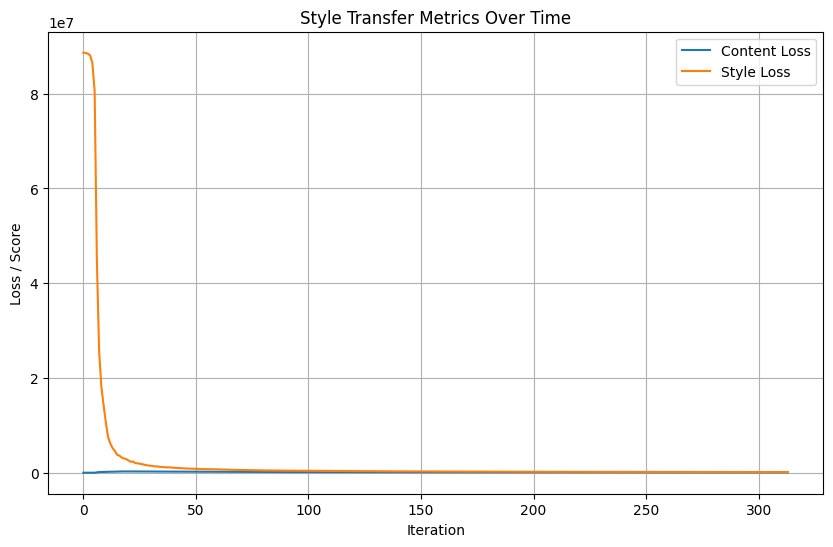


Running [1] houses_content_x_The_Visitor_by_Hennie_Niemann_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 27,513,770.00 | Content: 250,842.19 | Style: 25,913,512.00
LBFGS Step [20] Total: 5,641,909.00 | Content: 346,621.16 | Style: 3,980,441.75
LBFGS Step [30] Total: 4,027,856.00 | Content: 337,248.50 | Style: 2,502,011.00
LBFGS Step [40] Total: 2,945,674.50 | Content: 326,382.12 | Style: 1,584,955.75
LBFGS Step [50] Total: 2,429,677.25 | Content: 304,364.19 | Style: 1,246,770.00
LBFGS Step [60] Total: 2,117,170.25 | Content: 288,585.81 | Style: 1,044,631.62
LBFGS Step [70] Total: 1,902,513.62 | Content: 268,173.16 | Style: 907,910.44
LBFGS Step [80] Total: 1,725,711.50 | Content: 250,859.06 | Style: 782,681.25
LBFGS Step [90] Total: 1,602,513.50 | Content: 238,816.97 | Style: 694,613.06
LBFGS Step [100] Total: 1,513,219.75 | Content: 225,909.55 | Style: 636,427.81
LBFGS Step [110] Total: 1,428,914.75 | Content: 215,026.39 | Style: 574,854.56
LBFGS Step [120] Total: 1,371,60

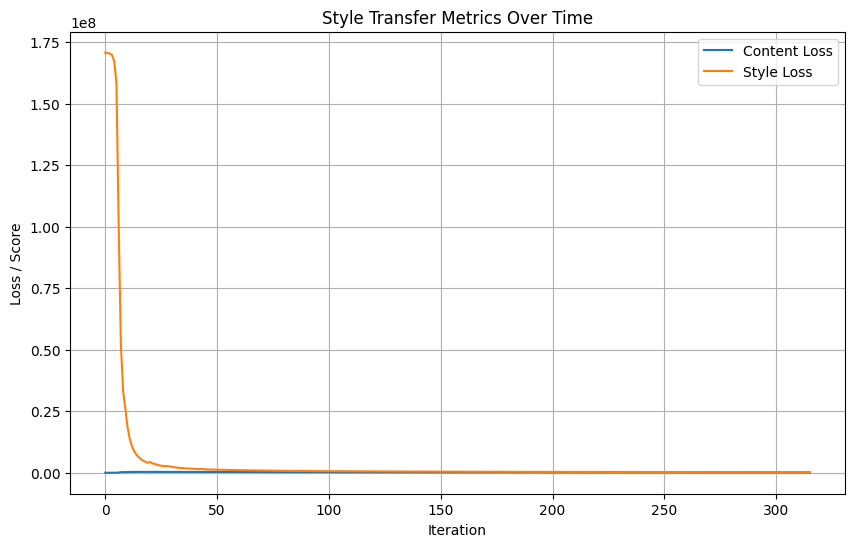


Running [2] houses_content_x_Tsunami_by_hokusai_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 53,483,120.00 | Content: 213,956.44 | Style: 51,584,520.00
LBFGS Step [20] Total: 11,160,058.00 | Content: 308,275.03 | Style: 8,385,144.00
LBFGS Step [30] Total: 6,582,345.00 | Content: 313,129.12 | Style: 3,862,808.50
LBFGS Step [40] Total: 4,737,890.00 | Content: 311,108.28 | Style: 2,192,577.75
LBFGS Step [50] Total: 3,988,153.50 | Content: 305,175.16 | Style: 1,651,414.00
LBFGS Step [60] Total: 3,551,386.50 | Content: 293,628.59 | Style: 1,297,368.62
LBFGS Step [70] Total: 3,247,198.50 | Content: 283,860.09 | Style: 1,096,525.38
LBFGS Step [80] Total: 3,013,013.25 | Content: 273,269.22 | Style: 902,190.75
LBFGS Step [90] Total: 2,849,148.50 | Content: 258,610.91 | Style: 799,128.38
LBFGS Step [100] Total: 2,734,238.25 | Content: 253,130.83 | Style: 719,471.25
LBFGS Step [110] Total: 2,630,221.00 | Content: 243,598.34 | Style: 645,151.38
LBFGS Step [120] Total: 2,549,372.50 | C

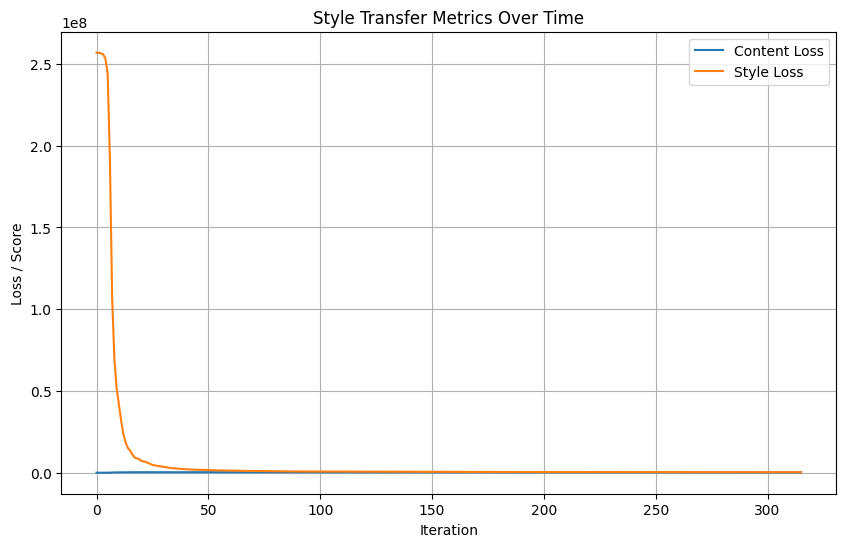


Running [3] houses_content_x_Vassily_Kandinsky,_1923_-_Composition_VIII_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 48,062,304.00 | Content: 195,493.56 | Style: 46,303,464.00
LBFGS Step [20] Total: 9,901,071.00 | Content: 294,065.47 | Style: 7,555,656.00
LBFGS Step [30] Total: 5,861,647.00 | Content: 296,959.66 | Style: 3,462,063.25
LBFGS Step [40] Total: 4,476,064.00 | Content: 298,170.31 | Style: 2,218,430.00
LBFGS Step [50] Total: 3,824,613.75 | Content: 292,083.50 | Style: 1,691,165.25
LBFGS Step [60] Total: 3,390,473.00 | Content: 282,766.81 | Style: 1,328,058.25
LBFGS Step [70] Total: 3,158,206.00 | Content: 273,213.09 | Style: 1,128,819.00
LBFGS Step [80] Total: 2,968,403.50 | Content: 263,618.97 | Style: 983,608.38
LBFGS Step [90] Total: 2,814,056.00 | Content: 254,139.72 | Style: 884,455.00
LBFGS Step [100] Total: 2,682,463.50 | Content: 245,760.58 | Style: 785,640.31
LBFGS Step [110] Total: 2,584,979.00 | Content: 236,831.50 | Style: 713,797.50
LBFGS Step [120] 

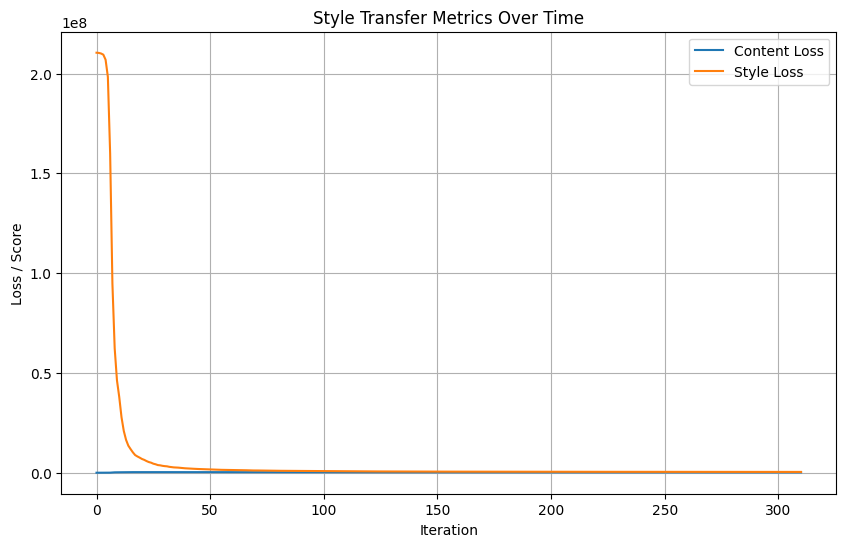


Running [4] houses_content_x_Water_Lillies_100.0_1000.0_0.0001_lbfgs_content
LBFGS Step [10] Total: 6,436,459.00 | Content: 168,348.77 | Style: 5,451,961.50
LBFGS Step [20] Total: 1,638,922.88 | Content: 215,562.53 | Style: 1,111,717.62
LBFGS Step [30] Total: 1,084,234.38 | Content: 169,241.86 | Style: 746,131.62
LBFGS Step [40] Total: 772,916.00 | Content: 136,054.27 | Style: 532,771.94
LBFGS Step [50] Total: 623,758.81 | Content: 119,557.29 | Style: 422,903.84
LBFGS Step [60] Total: 529,042.38 | Content: 105,392.64 | Style: 349,925.12
LBFGS Step [70] Total: 464,263.59 | Content: 93,264.38 | Style: 302,098.00
LBFGS Step [80] Total: 414,382.50 | Content: 88,092.56 | Style: 258,962.97
LBFGS Step [90] Total: 371,820.62 | Content: 81,263.63 | Style: 225,688.98
LBFGS Step [100] Total: 333,371.28 | Content: 77,501.98 | Style: 190,478.05
LBFGS Step [110] Total: 301,087.06 | Content: 74,252.29 | Style: 161,685.92
LBFGS Step [120] Total: 273,541.44 | Content: 68,680.30 | Style: 142,281.38
LBF

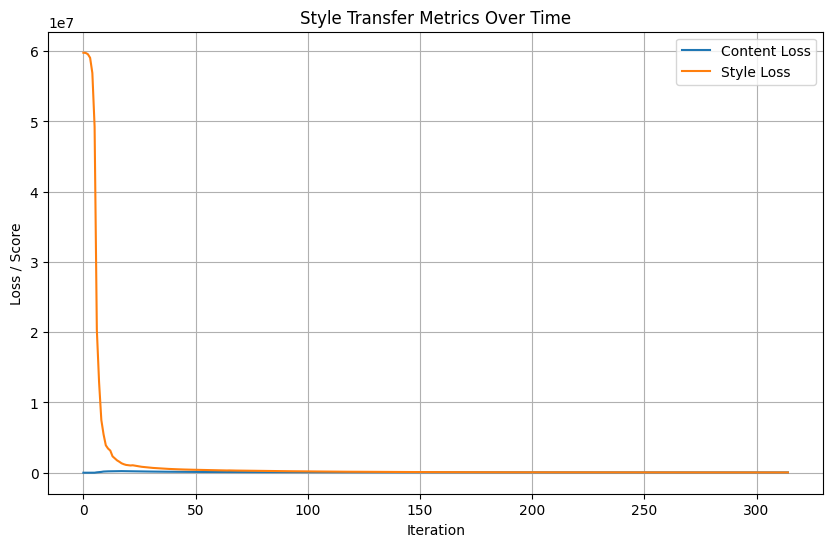

In [ ]:
# ===================================
# MAIN LOOP: APPLY TO ALL IMAGE PAIRS
# ===================================

run_index = 0

# Sort all valid image files
content_files = sorted([f for f in os.listdir(content_dir) if f.lower().endswith(('.jpg', '.png'))])
style_files = sorted([f for f in os.listdir(style_dir) if f.lower().endswith(('.jpg', '.png'))])

for content_file in content_files:
    for style_file in style_files:
        for cw, sw, tv, opt, init in product(content_weights, style_weights, tv_weights, optimizers, init_methods):

            run_id = f"{Path(content_file).stem}_x_{Path(style_file).stem}_{cw}_{sw}_{tv}_{opt}_{init}"
            output_name = f"{run_id}.jpg"

            content_path = os.path.join(content_dir, content_file)
            style_path = os.path.join(style_dir, style_file)
            output_path = os.path.join(output_dir, output_name)

            print(f"\nRunning [{run_index}] {run_id}")
            final_c, final_s, total_time = run_style_transfer(
                                          content_path, style_path, output_path,
                                          content_weight=cw,
                                          style_weight=sw,
                                          tv_weight=tv,
                                          optimizer_type=opt,
                                          init_type=init,
                                          iterations=300,
                                          learning_rate=10.0
            )

            # Log results to CSV
            with open(csv_log_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    run_index, run_id, content_file, style_file,
                    cw, sw, tv, opt, init, 300, 10.0,
                    final_c, final_s,
                    total_time,
                    output_path
                ])
            run_index += 1